## 빈도분석을 위한 데이터 크롤링 단계

- 빈도 분석에 앞서 크라우드 펀딩사이트인 wadiz 사이트의 프로젝트를 json파일로 가져와
  url을 통해 텍스트를 크롤링, 전처리를 하여 빈도분석을 위한 변수를 선언하는 것을 
  목표로 코드를 진행하게 되었다.

In [97]:
import requests
import json
from konlpy.tag import Komoran
TERM_POSES = ["NNP", "NNG", "XR"]

products=[]
categories=[]
amounts=[]
rates=[]
texts=[]
titles=[]
#products변수에 저장하기위해 리스트형태로 선언하였다.
detailurl="https://www.wadiz.kr/web/campaign/detail/"
#json파일에 저장되어있는 url id와 합치기 위한 프로젝트 url을 detailurl에 저장하였다.
with open("wadiz_products_ma_dic.jsonl", 'r', encoding='utf-8') as input_file:
    #앞서 정리한 jsonl파일을 불러온다.
    for line in input_file:
            #input_file을 한줄씩 읽어온다.
            product = json.loads(line)
            #line을 load한후 product에 저장한다.
            title=product["title"]
            #product에 저장된 정보들 중 title에 해당하는 value값을 title에 저장한다.
            category=product["custValueCodeNm"]
            #custvaluecodenm에 해당하는 value값을 category에 저장한다.
            urlnum=str(product["campaignId"])
            #urlnum에 product에서 campaignid에 해당하는 정보를 문자열로 저장한다.
            finalurl=detailurl+urlnum
            #기존에 프로젝트에 해당하는 url과 각 프로젝트 url id를 합쳐서 프로젝트별로 url을 저장한다.
            backamount=product["totalBackedAmount"]
            tmp=[]
            text=[]
            for sent in product["contents_ma"]:
                tmp=[lex.replace(" ","") for lex,pos in sent if pos in TERM_POSES]
                text.append(tmp)
            if product["achievementRate"]>=100:
                rate="SUCCESS"
            else:
                rate="FAIL"
            titles.append(title)
            categories.append(category)
            amounts.append(backamount)
            rates.append(rate)
            texts.append(text)
    products={
        "title":titles,
        "category":categories,
        "amount":amounts,
        "rate":rates,
        "text":texts
    }

In [4]:
s_titles = []
s_categories  = []
s_final_text=[]
s_amount=[]
s_rate=[]
#성공한
f_titles = []
f_categories  = []
f_final_text=[]
f_amount=[]
f_rate=[]
#실패한

In [101]:
products["category"][1]

'패션·잡화'

In [154]:
for idx, rate in enumerate(products["rate"]):
    if products["category"][idx]==None:
        print(idx)
        continue
    if rate=="SUCCESS":
        
        s_titles.append(products["title"][idx])
        s_categories.append(products["category"][idx])
        s_amount.append(products["amount"][idx])
        s_rate.append(products["rate"][idx])
        s_final_text.append(products["text"][idx])
    else:
        if products["category"][idx]==None:
            print("a")
            break
        f_titles.append(products["title"][idx])
        f_categories.append(products["category"][idx])
        f_amount.append(products["amount"][idx])
        f_rate.append(products["rate"][idx])
        f_final_text.append(products["text"][idx])
    
products_suc = {
    "title" : s_titles,
    "category" : s_categories,
    "amount":s_amount,
    "text_word":s_final_text
}
products_fail = {
    "title" : f_titles,
    "category" : f_categories,
    "amount":f_amount,
    "text_word":f_final_text
}

7602
7618


## column oriented data 변형단계

- 데이터를 크롤링해 기본적인 형태소 분석과 전처리를 마친 후, 빈도분석과 분석하려는 그래프에 적합하게 열기준의 데이터로 변환하는 코드를 작성하였다. 프로젝트를 성공한 프로젝트와 실패한 프로젝트 두 가지 사례로 살펴보고자 성공한 프로젝트의 타이틀과 카테고리, 텍스트와 후원금액을 담는 리스트와 실패한 데이터를 담는 리스트를 개별 선언한 후, 그래프로 분석하였다.

In [119]:
from collections import Counter
from itertools import chain

In [153]:
s_body_word_sets=[set(chain(*article)) for article in products_suc["text_word"]]

In [140]:
s_body_word_counts=[Counter(chain(*article)) for article in products_suc['text_word']]

In [141]:
suc_category=list(set(products_suc["category"]))
fail_category=list(set(products_fail["category"]))

In [155]:
s_proset_text={}
s_procount_text={}
s_prowl_text = {}

for cat in suc_category:
    s_proset_text[cat]=set(chain(*[w for idx,w in enumerate(s_body_word_sets) if products_suc["category"][idx]==cat]))
    #단어 리스트(body_word_sets)에서 단어를 꺼내되 products_col의 category에 맞게 집합되어 들어가게 됨.
    s_procount_text[cat] =Counter(chain(*[c for idx,c in enumerate(s_body_word_counts) if products_suc["category"][idx]==cat]))
    #단어 리스트(body_word_sets)에서 #단어 리스트(body_word_sets)에서 단어를 꺼내되 products_col의 category에 맞게 count하여 들어가게 됨.
    s_prowl_text[cat]= list(chain(*[w for idx,w in enumerate(products_suc['text_word']) if products_suc["category"][idx]==cat]))
    #단어 리스트(body_word_sets)에서 단어를 꺼내되 products_col의 category에 맞게 count하여 리스트에 들어가게 됨.

## TF-IDF

-  프로젝트의 이름과 카테고리, 게시글임으로 3가지의 데이터만을 추출하여 딕셔너리에 
  저장하였다.빈도 분석을 시작하기 전, 카테고리별로 게시글을 통합하기 위해 기준 변수인 category를
  선언하고, 전체적으로 카테고리가 어떤식으로 구성되어 있는지 확인하기 위해
  다음과 같은 코드를 작성하였다.

In [156]:
def return_countcat(temp):
    final=[]
    for name,num in temp.items():
        final.append(name)
    return final

In [164]:
!pip install collections-extended

In [167]:
from collections import Counter
from itertools import chain
#단어의 빈도를 세기위한 모듈과 list를 묶기 위해 chain 모듈을 선언.
count_cate_suc=[]
count_cate_fail=[]
cate_count_suc=Counter(products_suc["category"])
cate_count_fail=Counter(products_fail["category"])

#cate_count에 category의 개수를 count하여 저장하였음.
for category,count in cate_count_suc.items():
    #counter변수를 for문에 활용하기 위해 items를 사용하였음.
    count_cate_suc.append(count)
for category,count in cate_count_fail.items():
    #counter변수를 for문에 활용하기 위해 items를 사용하였음.
    count_cate_fail.append(count)

category_suc=return_countcat(cate_count_suc)
category_fail=return_countcat(cate_count_fail)

In [168]:
cate_count_fail

Counter({'홈리빙': 1719,
         '뷰티': 1180,
         '디자인소품': 3620,
         '패션·잡화': 5997,
         '스포츠·모빌리티': 704,
         '공연·컬쳐': 1406,
         '테크·가전': 1721,
         '반려동물': 1274,
         '소셜·캠페인': 2917,
         '여행·레저': 839,
         '게임·취미': 391,
         '푸드': 1946,
         '교육·키즈': 796,
         '출판': 799,
         None: 1})

In [131]:
cate_count_fail

Counter({'홈리빙': 471,
         '뷰티': 324,
         '디자인소품': 1008,
         '패션·잡화': 1641,
         '스포츠·모빌리티': 198,
         '공연·컬쳐': 420,
         '테크·가전': 495,
         '반려동물': 348,
         '소셜·캠페인': 873,
         '여행·레저': 237,
         '게임·취미': 111,
         '푸드': 540,
         '교육·키즈': 222,
         '출판': 231,
         None: 1})

In [130]:
import pandas as pd
import plotnine
from plotnine import *
import matplotlib.pyplot as pl

theme_update(text=element_text(family="malgun gothic",size=6))
plot_suc_count=pd.DataFrame({"category":category_suc,"count":count_cate_suc})
plot_fail_count=pd.DataFrame({"category":category_fail,"count":cate_count_fail})

TypeError: '<' not supported between instances of 'NoneType' and 'str'

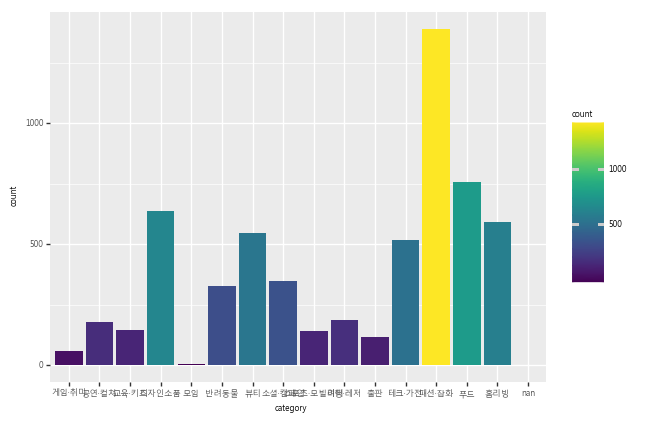

<ggplot: (-9223372036819652657)>

In [70]:
(ggplot(plot_suc_count)+geom_col(aes('category', 'count', fill='count')))

- 성공한 프로젝트의 경우

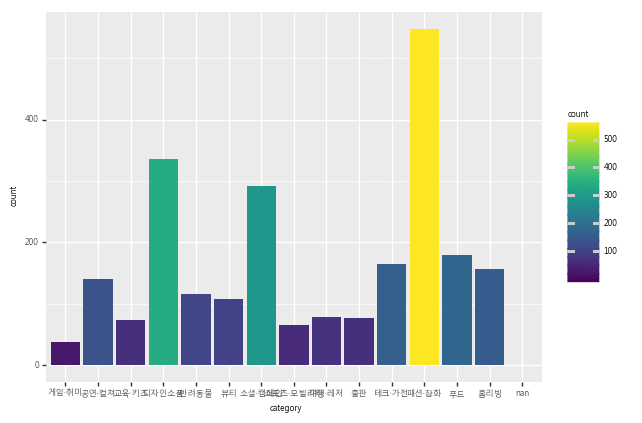

<ggplot: (32081714)>

In [71]:
(ggplot(plot_fail_count)+geom_col(aes('category', 'count', fill='count')))

- 실패한 프로젝트의 경우

## 카테고리별 평균 후원 금액

- 카테고리 별 후원 금액의 경우, 카테고리별로 후원금액을 저장할 수 있는 딕셔너리 변수를 선언하여 기존 데이터에서 후원금액을 더해 저장한후, 기존 데이터의 카테고리대로 정리된 후원금액을 리스트로 반환해주는 함수를 선언하였다.

In [72]:
def amount(products,category,count):
    temp={}
    final=[]
    num=0
    for cat in category:
        a=0
        temp.update({cat:a})
    for cat in category:
        for i in range(0,len(products["category"])):
            if products["category"][i]==cat:
                a=temp[cat]
                total=products["amount"][i]+a
                temp[cat]=total
    for cat in category_suc:
        final.append(temp.pop(cat)/count[num])
        num+=1
    return final

In [74]:
category_fail

['홈리빙',
 '뷰티',
 '디자인소품',
 '패션·잡화',
 '스포츠·모빌리티',
 '공연·컬쳐',
 '테크·가전',
 '반려동물',
 '소셜·캠페인',
 '여행·레저',
 '게임·취미',
 '푸드',
 '교육·키즈',
 '출판',
 None]

In [73]:
suc_amount=amount(products_suc,category_suc,count_cate_suc)
fail_amount=amount(products_fail, category_fail,count_cate_fail)

KeyError: '모임'

In [57]:
plot_suc_amount=pd.DataFrame({"category":category_suc,"count":suc_amount})
plot_fail_amount=pd.DataFrame({"category":category_fail,"count":fail_amount})

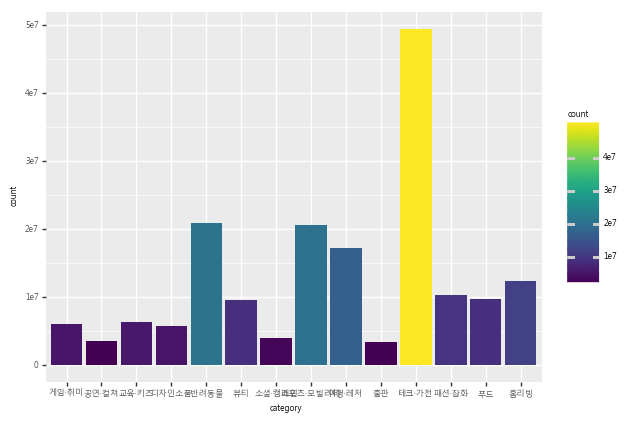

<ggplot: (104705158)>

In [58]:
(ggplot(plot_suc_amount)+geom_col(aes('category', 'count', fill='count')))

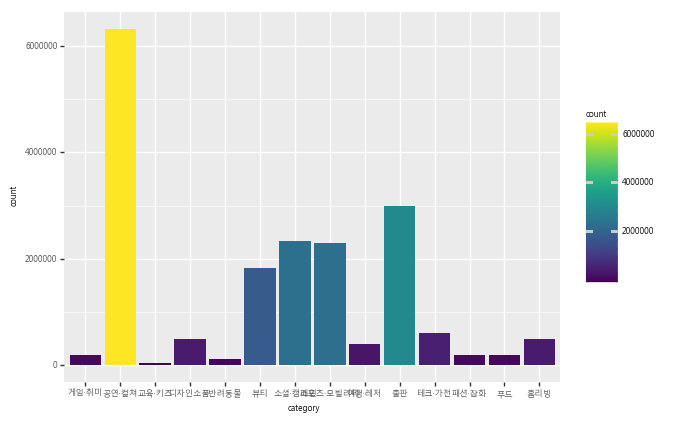

<ggplot: (104681999)>

In [59]:
(ggplot(plot_fail_amount)+geom_col(aes('category', 'count', fill='count')))

## 빈도분석을 위한 변수 선언 단계

- 카테고리별로 단어를 세분화해 텍스트 마이닝과 빈도 분석을 진행하는 것이 목표였으므로
  빈도분석과 유니그램을 진행하기 위한 counter형식으로 생성된 리스트변수와 set형식으로 
  생성된 리스트 변수를 선언하였다.

In [31]:
s_titles = []
s_categories  = []
s_final_text=[]
s_amount=[]
s_rate=[]
#성공한
f_titles = []
f_categories  = []
f_final_text=[]
f_amount=[]
f_rate=[]
#실패한

KeyError: 'category'

In [172]:
body_word_sets=[set(chain(*article)) for article in products_suc["text_word"]]
#기존 변수에서 텍스트를 도출한 article을 리스트를 해체해 중복되는 단어를 제거한 body_word_sets를선언.
body_word_counts=[Counter(chain(*article)) for article in products_suc['text_word']] 
#기존 변수에서 텍스트를 도출한 article을 리스트를 해체해 묶은 후 count하여 리스트형태로 body_word_counts 선언

MemoryError: 

In [1]:
#body_word_set 게시글별로 단어 정리 리스트안 딕셔너리 형태
#body_word_count  게시글별로 단어 카운트. 리스트안 딕셔너리 형태

In [ ]:
proset_text={}
procount_text={}
prowl_text = {}
#데이터 분석을 용이하게 하기 위해 딕셔너리 형태로 변수를 선언하고자 했다.
#따라서 for문을 시작하기 전 딕셔너리 변수를 먼저 선언하였다.
for cat in category_suc:
    proset_text[cat]=set(chain(*[w for idx,w in enumerate(body_word_sets) if products_suc["category"][idx]==cat]))
    #단어 리스트(body_word_sets)에서 단어를 꺼내되 products_col의 category에 맞게 집합되어 들어가게 됨.
    procount_text[cat] =Counter(chain(*[c for idx,c in enumerate(body_word_counts) if products_suc["category"][idx]==cat]))
    #단어 리스트(body_word_sets)에서 #단어 리스트(body_word_sets)에서 단어를 꺼내되 products_col의 category에 맞게 count하여 들어가게 됨.
    prowl_text[cat]= list(chain(*[w for idx,w in enumerate(products_suc['text_word']) if products_suc["category"][idx]==cat]))
    #단어 리스트(body_word_sets)에서 단어를 꺼내되 products_col의 category에 맞게 count하여 리스트에 들어가게 됨.

## tf

In [63]:
import math

doc_sets=[c for m,c in proset_text.items()] 
#set으로 저장된 리스트에서도 단어만이 저장된 딕셔너리를 가진, 카테고리별로
#분류가 되어있는 doc_sets 리스트 변수 선언

def get_document_frequency(word_sets):
    vocabulary=set.union(*word_sets)
    #단어만이 저장된 딕셔너리 변수선언
    freq=Counter()
    for word in vocabulary:
        #단어집합에서 word 추출
        for word_set in word_sets:
            #하나의 카테고리에서 단어 하나 추출
            if word in word_set: 
                #전체단어사전에서 word가 존재할 경우
                freq[word]+=1 #freq에서 count함.
    return freq
     #freq 반환
doc_freq=get_document_frequency(doc_sets)
#doc_freq변수로 함수활용해 선언

In [65]:
doc_counts=[c for m,c in procount_text.items()] 

def get_term_freq(word_counts):
    term_freqs=[]
    #함수를 통해 반환할 리스트 선언
    for word_count in word_counts:
        #for문 실행.
        term_freq = Counter()
        #단어를 count할 새로운 counter 변수 선언.
        for word, count in word_count.items():
            #counter안의 단어와 count한 숫자가 items로 각각 word와 count로 들어가게 됨
            term_freq[word] = math.log(count + 1) 
            #tf공식을 활용하여 단어들의 빈도수를 체크하였음
        term_freqs.append(term_freq)
        #term_freqs에 append하였음
    return term_freqs
    #반환

term_freqs=get_term_freq(doc_counts)

## DF

## IDF

In [67]:
N_DOCS=len(category_suc)
#분야의 개수 저장
def get_idf(doc_freq, N):
#idf를 위한 함수 선언. 카테고리의 수와 전체
    idf=Counter()
    #카운트를 하기위한 idf 변수 선언
    for word, count_all in doc_freq.items():
        #카운트 변수에서 word와 count를 꺼낸다.
        idf[word]=math.log(N/(count_all+1))
        #idf에서 공식을 활용한 코드를 거친후 저장
    return idf
    #idf 반환

In [69]:
inv_doc_freq=get_idf(doc_freq,N_DOCS)
#기존에 만든 doc_freq변수와 카테고리 개수를 입력하여 변수 선언

## TFIDF

In [70]:
#tf-idf를 위한 함수 선언
def get_tfidf(tfs,idf):
    tfidfs=[]
    #tfidf
    for tf in tfs:
        #tfs를 for문을 활용해 실행
        tfidf=Counter()
        #단어의 빈도를 세기 위해 fdidf변수 선언
        for term, freq in tf.items():
            #카운터인 if의 word와 count를 items로 나타냄
            tfidf[term]=freq+idf[term]
            #기존 카운터 변수에 빈도수와 inverse document를 해 나타난 단어의 빈도를 더해 저장
        tfidfs.append(tfidf)
        #기존에 생성한 리스트 변수에 append 
    return tfidfs
    #tfidfs리스트 반환 
doc_tfidfs=get_tfidf(term_freqs, inv_doc_freq)
#term_freq와 inv_doc_freq 변수를 함수를 활용해 변수 선언

In [71]:
for idx, cat in enumerate(category_suc):
    #category를 for문을 활용해 doc_tfidf에 저장된 단어를 카테고리별로 출력
    print("=== {} ===".format(cat))
    keywords = [k for k, v in doc_tfidfs[idx].most_common(15)]
    #가장 많이 도출된 단어 15개를 출력
    print(", ".join(keywords))
    #출력함
    print()

=== 푸드 ===
칼로리, 맛, 단맛, 유통기한, 설탕, 제품, 배, 워드, 후, 건강, 식품, 사용, 가능, 송, 냉장

=== 패션·잡화 ===
원단, 제품, 착용, 워드, 가능, 사용, 후, 제작, 디즈, 프로젝트, 와, 배, 문의, 송, 교환

=== 반려동물 ===
반려, 강아지, 고양이, 보호자, 제품, 수의사, 동물, 사용, 집사, 견, 가능, 후, 진행, 배, 때

=== 뷰티 ===
스킨케어, 앰플, 보습, 세안, 지성, 부결, 메이크업, 화장품, 성분, 피부, 제품, 히알루론산, 토너, 에센스, 클렌징

=== 홈리빙 ===
제품, 사용, 가능, 디즈, 와, 후, 경우, 워드, 시작, 배, 때, 프로젝트, 송, 서, 전

=== 테크·가전 ===
제품, 사용, 가능, 블루투스, 후, 프로젝트, 전, 고속, 디즈, 포터, 와, 워드, 기기, 서, 문의

=== 여행·레저 ===
수하물, 원단, 사용, 후, 가능, 프로젝트, 워드, 경우, 확인, 디즈, 변경, 와, 전, 페이지, 교환

=== 스포츠·모빌리티 ===
라켓, 근력, 제품, 디즈, 배, 사용, 경우, 후, 미니벨로, 시마노, 차체, 크랭크, 기술자들, 테니스, 와

=== 디자인소품 ===
가능, 디즈, 제품, 사용, 배, 워드, 송, 제작, 프로젝트, 와, 후, 일, 전, 생각, 시작

=== 소셜·캠페인 ===
시내, 포스트잇, 발달 장애, 사교, 폐사, 부화, 뮤신, 카리아, 시트로넬라, 스테이트, 마크리, 스타이렌, 씨에스피, 월롱면, 회동

=== 게임·취미 ===
파국, 통칭, 브레이, 예감, 석고, 참담, 넋두리, 날밤, 악필, 래빗, 신호 전달, 구면, 시다, 절절, 멍청

=== 공연·컬쳐 ===
보컬, 공연장, 관객, 초대권, 뮤지, 공연, 양도, 강좌, 연극, 로맨스, 2호선, 선율, 연주자, 음악가, 대관

=== 출판 ===
책갈피, 표지, 산티아고, 순례, 중독자, 순례자, 축소판, 파울로 코엘료, 전환점, 학기, 밥값, 묵시, 백날, 알베르, 포르투

=

In [243]:
def stopword(temp):
    stopwords=[]
    for idx in range(0,len(doc_tfidfs)):
        sort=sorted(temp[idx].items(), key=lambda pair: pair[1])
        for sort_test in sort[1].values():
            if sort_test<0.59:
                stopwords.extend(str(sort.keys()))
        return stopwords

In [82]:
wordcloud_tfidf={}

for num,cat in enumerate(category_suc):
    wordcloud_tfidf.update({cat:doc_tfidfs[num]})

Counter({'성공': 4.640537329825382,
         '바나나': 3.1498829533812494,
         '치아': 2.6390573296152584,
         '미백': 4.916324614625014,
         '게': 3.9740583963475986,
         '커피': 2.5336968139574325,
         '간식': 2.169053700369523,
         '카레': 2.8622008809294686,
         '담배': 2.639057329615259,
         '기분': 3.289644895756408,
         '와인': 2.505525936990736,
         '한잔': 2.6390573296152584,
         '평범': 3.1986731175506815,
         '생활': 3.692207244206611,
         '착색': 3.1986731175506815,
         '양치질': 2.8622008809294686,
         '치약': 2.6390573296152584,
         '속도': 2.7191000372887952,
         '미세': 4.155404818983347,
         '구멍': 2.351375257163478,
         '속': 4.484884020113589,
         '방법': 4.505718107016431,
         '안녕하세요': 4.419643498245188,
         '노력': 4.135699747904014,
         '해': 2.9873640238834747,
         '베': 2.7343675094195836,
         '고민': 4.72679767410979,
         '오랫동안': 3.709498741316672,
         '조사': 3.8807704619240413

## 워드 클라우드

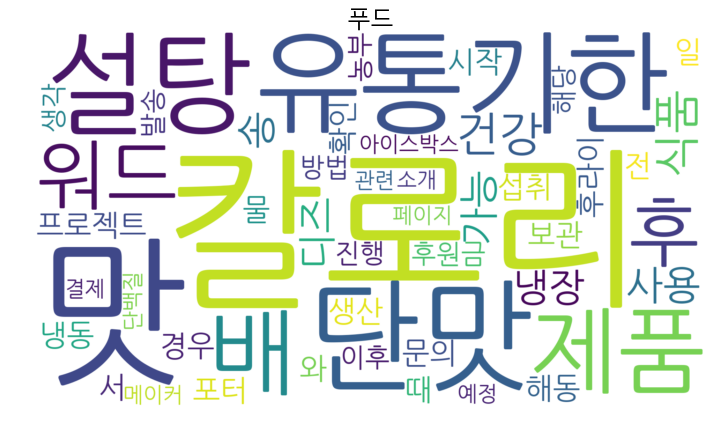

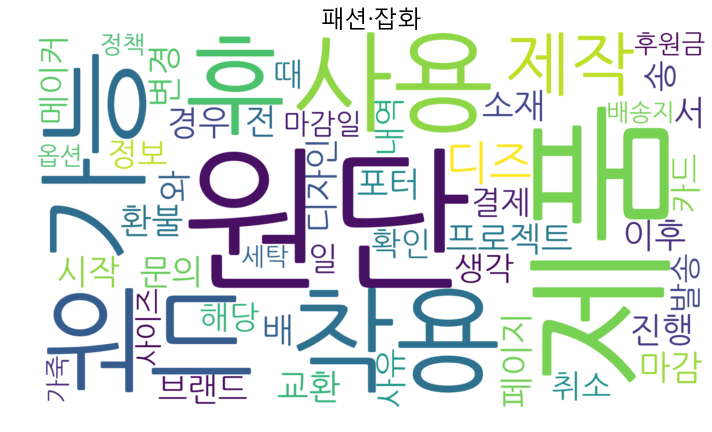

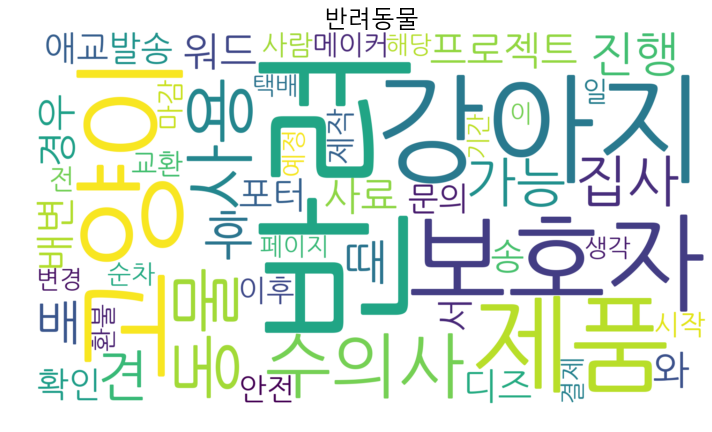

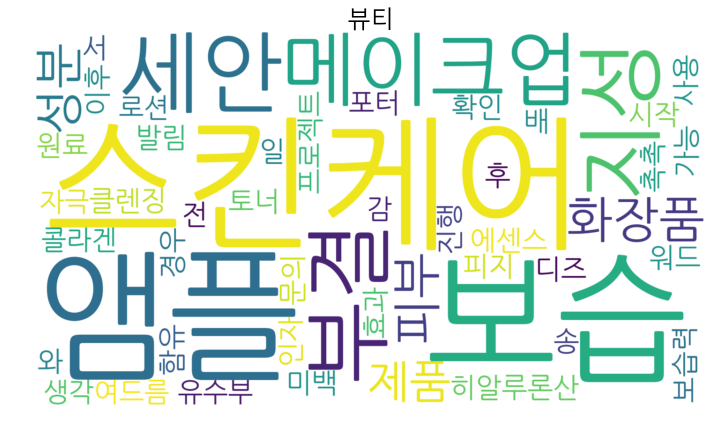

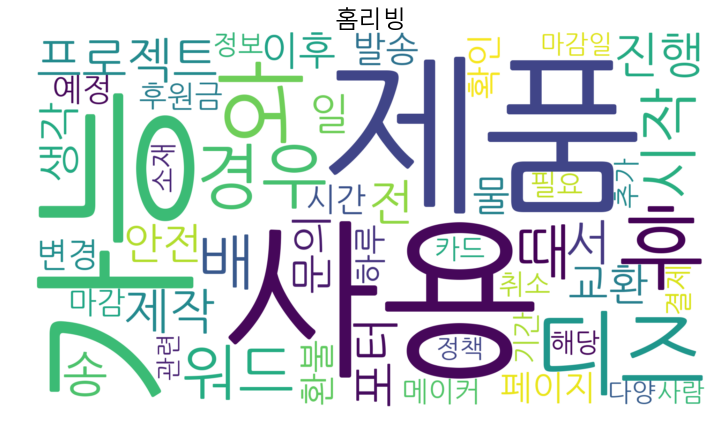

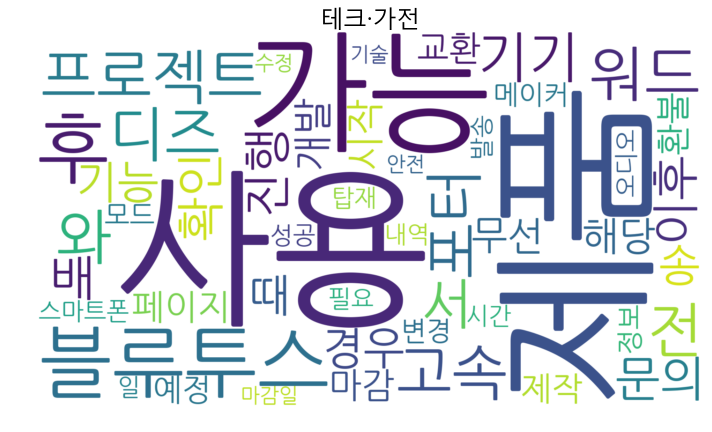

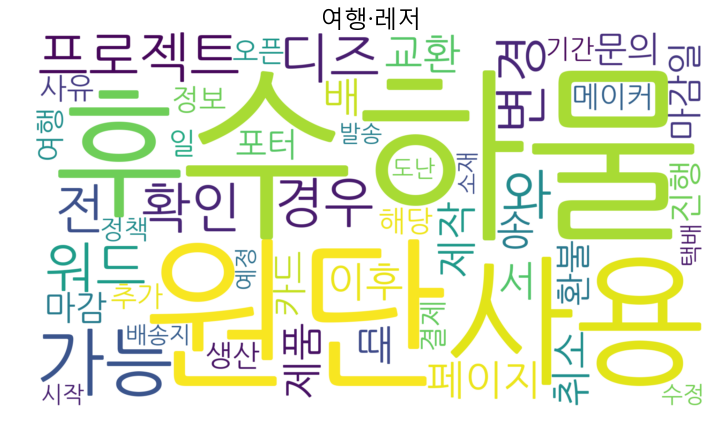

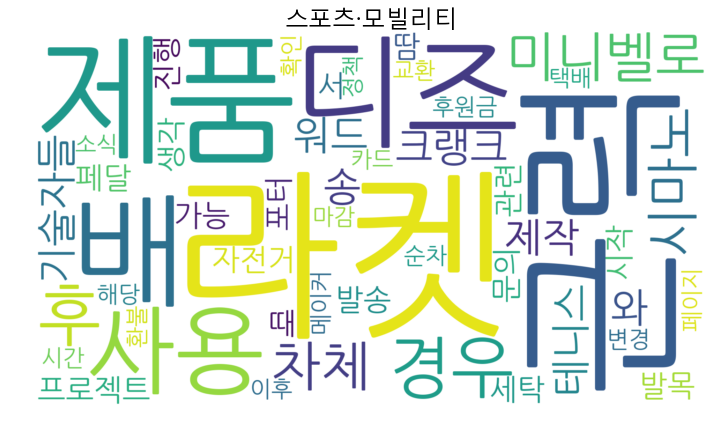

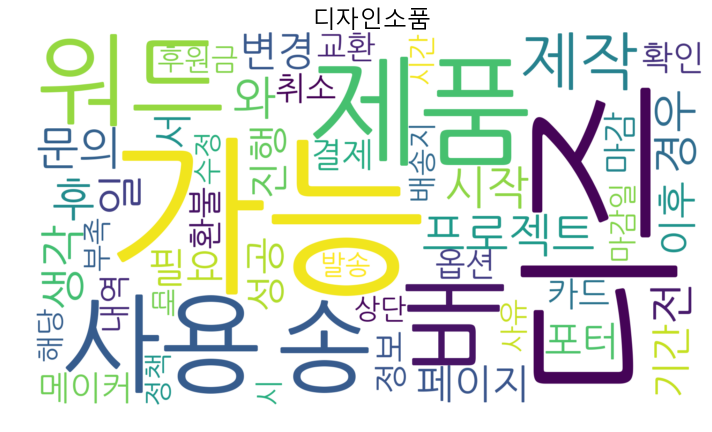

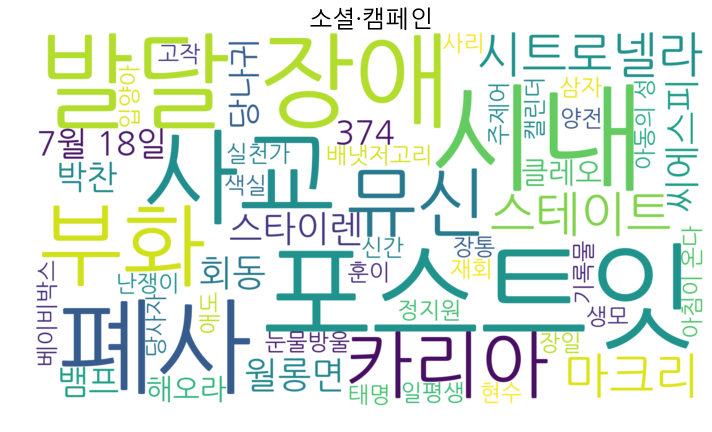

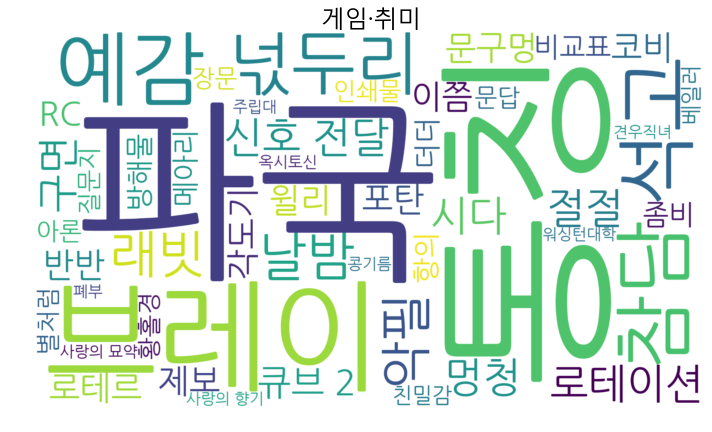

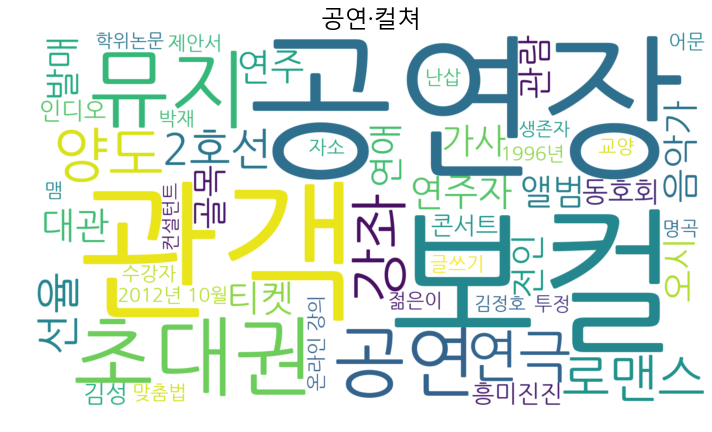

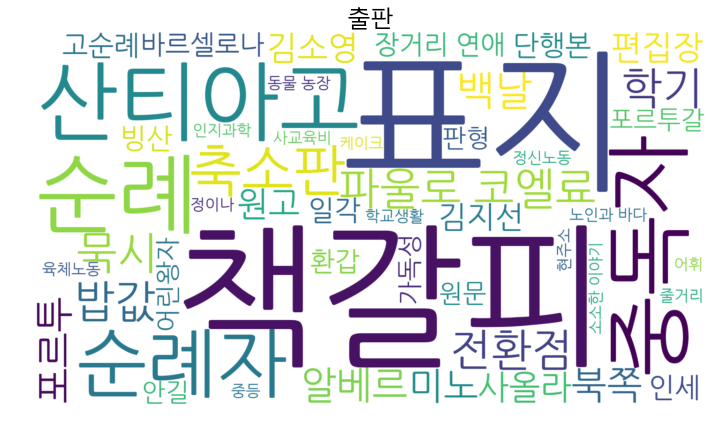

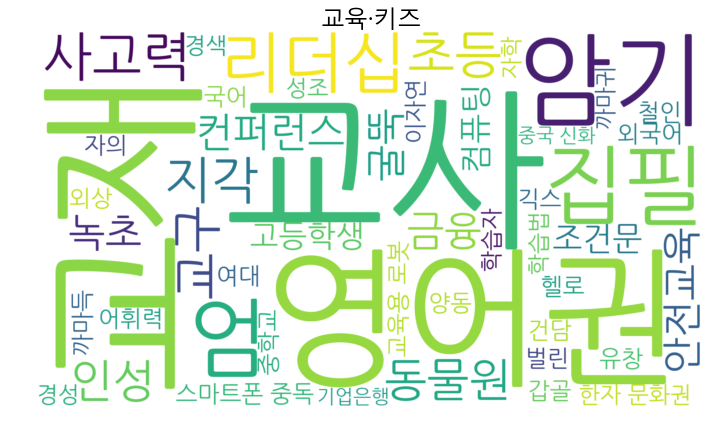

In [84]:
import wordcloud
import matplotlib.pyplot as plt
import numpy as np

N_WORDS = 50

plt.rc('font', family='malgun gothic')
#plt에 맑은 고딕으로 글씨체를 지정하여 줌.
wc = wordcloud.WordCloud(background_color="white", font_path = 'NanumGothic.ttf',max_words = N_WORDS, collocations=False, width=1920, height=1080)
#wc에 바탕색깔과 폰트를 지정하고 max_word와 가로,세로 길이 지정.
for cat in category_suc:
    #category별로 for문을 실행.
    wc.generate_from_frequencies(wordcloud_tfidf[cat]) 
    #기존에 설정을 저장한 wc에서 procunt_text를 카테고리별로 실행.
    plt.title(cat, fontsize=24)
    #font size 지정
    plt.imshow(wc, interpolation= 'bilinear')
    #플롯 지정
    plt.axis('off')
    # 축 off
    plt.gcf().set_size_inches(12, 10)
    #size inch 설정
    plt.show()
    #출력

- 단순 빈도 분석의 경우에는 카테고리별로 단어가 상이하게 나오기 보다 전체적으로 
  카테고리별로 동일한 것을 확인할 수 있었다. 이에 따라, TF-IDF를 실행하여 
  각 카테고리별로 '유의미'한 단어를 도출해내고자 아래와 같은 코드를 실행하게 되었다.

In [164]:
from textblob.classifiers import NaiveBayesClassifier
import collections
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [165]:
def word_list(category,products):
    word=[]
    num=0
    for cat in category:
        a=list(chain(*chain(*[w for idx, w in enumerate(products['text_word']) if products["category"][idx]==cat])))
        word.append(a)
    return word

In [166]:
pos_list=word_list(category_suc,products_suc)
neg_list=word_list(category_fail,products_fail)

In [167]:
def neg_tupleword(just_word):
    tuple_word=[]
    temp=[]
    for i in range(0,len(just_word)):
        for idx in range(0,len(just_word[i])):
            a=(just_word[i][idx],"부정")
            temp.append(a)
    
    tuple_word.append(temp)
    return tuple_word

In [168]:
def pos_tupleword(just_word):
    tuple_word=[]
    temp=[]
    for i in range(0,len(just_word)):
        for idx in range(0,len(just_word[i])):
            a=(just_word[i][idx],"긍정")
            temp.append(a)
    
    tuple_word.append(temp)
    return tuple_word

In [169]:
pos_list=pos_tupleword(pos_list)
neg_list=neg_tupleword(neg_list)

In [170]:
final=[]
final.extend(pos_list)
final.extend(neg_list)
final=list(chain(*final))

In [142]:
documents = []

for sent in products["text"]:
    sent_m = " ".join(chain(*sent))
    documents.append(sent_m)
        
train_documents, test_documents, train_labels, test_labels = train_test_split(documents, products["rate"])
train_documents, test_documents, train_labels, test_labels = train_test_split(documents, products["rate"])

vectorizer = CountVectorizer(tokenizer=str.split)
train_doc = vectorizer.fit_transform(train_documents)
test_doc = vectorizer.transform(test_documents)

clf = MultinomialNB().fit(train_doc, train_labels)
pred_labels = clf.predict(test_doc)
accuracy = accuracy_score(test_labels, pred_labels)

print("Accuracy: {}".format(accuracy))    

In [147]:
import nltk

In [161]:
cl=NaiveBayesClassifier(final)

MemoryError: 

MemoryError: 